In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mustard-multimodal-sarcasm-detection-dataset/sarcasm_data.json
/kaggle/input/mmsd-wav-data/mmsd_wav_data/mustard_manifest.csv
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/1_2842_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/1_6683_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/2_367_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/2_160_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/2_205_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/2_523_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/2_486_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/2_393_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/1_11699_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/2_442_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/1_9668_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_data/context_final/1_7575_c.wav
/kaggle/input/mmsd-wav-data/mmsd_wav_d


**To implement hyperparameter tuning, we can use techniques like grid search or random search. Given the complexity of hyperparameter tuning, I'll focus on a more simplified approach for adjusting key hyperparameters like the learning rate, batch size, the number of GATConv layers, and hidden dimensions.**



**We tune:**


* Learning Rate: Try different values for the learning rate (e.g., 1e-4, 1e-3, 3e-4).
* Batch Size: Experiment with different batch sizes (e.g., 2, 4, 8).
* Hidden Dimension: Experiment with different hidden dimensions (e.g., 128, 256).
* Number of GATConv Layers: Try different numbers of GATConv layers (e.g., 3, 4).




**To simplify the implementation, we will perform a manual grid search for a small set of hyperparameters, train the model with each configuration, and track the performance.**


In [2]:
# # Upgrade pip first
# !pip install -q --upgrade pip

# # Install PyTorch Geometric (CUDA 11.8 for Kaggle GPUs)
# !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
#     -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__)")+cu118.html

# # Install HuggingFace Transformers & Torchaudio
# !pip install -q transformers torchaudio

# # Install Scikit-learn, Pandas, NumPy
# !pip install -q scikit-learn pandas numpy


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'torch-scatter' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'torch-scatter'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'torch-sparse' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to 

In [2]:
# pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
import torch
import torchaudio
import numpy as np
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel, Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Paths
JSON_PATH = "/kaggle/input/mustard-multimodal-sarcasm-detection-dataset/sarcasm_data.json"
AUDIO_DIR = "/kaggle/input/mmsd-wav-data/mmsd_wav_data/utterances_final/"
GRAPH_DIR = "/kaggle/working/graphs_dict"
os.makedirs(GRAPH_DIR, exist_ok=True)

# Load dataset
with open(JSON_PATH) as f:
    data_json = json.load(f)

utterances, labels, audio_paths = [], [], []
for key, value in data_json.items():
    wav_path = os.path.join(AUDIO_DIR, f"{key}.wav")
    if os.path.exists(wav_path):
        utterances.append(value['utterance'])
        labels.append(int(value['sarcasm']))
        audio_paths.append(wav_path)

# Models for feature extraction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
text_model = RobertaModel.from_pretrained("roberta-base").to(device)

wav_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

def extract_text_features(text):
    inputs = text_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
    return outputs.last_hidden_state.squeeze(0).cpu()

def extract_audio_features(wav_path):
    waveform, sr = torchaudio.load(wav_path)
    waveform = waveform.squeeze()
    inputs = wav_processor(waveform, sampling_rate=sr, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = wav_model(**inputs)
    return outputs.last_hidden_state.squeeze(0).cpu()

def extract_prosody_features(waveform, sr):
    pitch = torchaudio.functional.detect_pitch_frequency(waveform, sr)
    energy = waveform.pow(2).mean(dim=1)
    return torch.stack([pitch.mean(), energy.mean()]).unsqueeze(0)

# Build and save graphs
from torch_geometric.data import Data

graphs = []
for idx, (utt, lbl, wav_path) in enumerate(tqdm(zip(utterances, labels, audio_paths), total=len(labels))):
    # Extract features
    text_feat = extract_text_features(utt)             # (T_text, 768)
    audio_feat = extract_audio_features(wav_path)      # (T_audio, 768)
    waveform, sr = torchaudio.load(wav_path)
    prosody_feat = extract_prosody_features(waveform, sr)  # (1, 2)

    # Node features (concat prosody dims to match size later)
    prosody_proj = torch.nn.functional.pad(prosody_feat, (0, 766))  # (1, 768)
    x = torch.cat([text_feat, audio_feat, prosody_proj], dim=0)

    # Node types: 0=text, 1=audio, 2=prosody, 3=global
    node_type = torch.cat([
        torch.zeros(text_feat.size(0), dtype=torch.long),
        torch.ones(audio_feat.size(0), dtype=torch.long),
        torch.full((1,), 2, dtype=torch.long),
        torch.full((1,), 3, dtype=torch.long)
    ])

    # Add global node
    global_node = torch.zeros(1, 768)
    x = torch.cat([x, global_node], dim=0)

    # Simple fully connected edges for example (customize if needed)
    num_nodes = x.size(0)
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # undirected

    data = Data(x=x, edge_index=edge_index, y=torch.tensor([lbl], dtype=torch.long), node_type=node_type)
    torch.save(data, os.path.join(GRAPH_DIR, f"{idx}.pt"))

from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader  # FIX: use PyG DataLoader
from torch_geometric.data import Data
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import numpy as np

# Dataset loader
class GraphDictDataset(Dataset):
    def __init__(self, graph_paths):
        self.graph_paths = graph_paths
    def __len__(self):
        return len(self.graph_paths)
    def __getitem__(self, idx):
        return torch.load(self.graph_paths[idx], weights_only=False)  # FIX: Safe load

# Train/val split
graph_files = sorted([os.path.join(GRAPH_DIR, f) for f in os.listdir(GRAPH_DIR)])
labels_all = [torch.load(f, weights_only=False).y.item() for f in graph_files]
train_idx, val_idx = train_test_split(range(len(graph_files)), test_size=0.2, stratify=labels_all, random_state=42)

# Reduce batch size to fit GPU memory
train_loader = DataLoader(GraphDictDataset([graph_files[i] for i in train_idx]), batch_size=2, shuffle=True)
val_loader = DataLoader(GraphDictDataset([graph_files[i] for i in val_idx]), batch_size=2)

# Model
class TypeProjector(nn.Module):
    def __init__(self, in_dim, out_dim, num_types):
        super().__init__()
        self.embs = nn.ModuleList([nn.Linear(in_dim, out_dim) for _ in range(num_types)])
    def forward(self, x, node_type):
        out = torch.zeros(x.size(0), self.embs[0].out_features, device=x.device)
        for t in range(len(self.embs)):
            mask = node_type == t
            out[mask] = self.embs[t](x[mask])
        return out

class CMGAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, num_types=4, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 3)
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)

# Hyperparameter grid search
lr_options = [1e-4, 3e-4, 1e-3]
batch_size_options = [2, 4, 8]
hidden_dim_options = [128, 256]
num_layers_options = [3, 4]

best_model = None
best_f1 = 0
best_params = {}

# Iterate over all combinations of hyperparameters
for lr in lr_options:
    for batch_size in batch_size_options:
        for hidden_dim in hidden_dim_options:
            for num_layers in num_layers_options:
                print(f"Training with lr={lr}, batch_size={batch_size}, hidden_dim={hidden_dim}, num_layers={num_layers}")
                
                model = CMGAT(in_dim=768, hidden_dim=hidden_dim, num_classes=2, num_layers=num_layers).to(device)

                class_weights = compute_class_weight("balanced", classes=np.unique(labels_all), y=labels_all)
                class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
                loss_fn = nn.CrossEntropyLoss(weight=class_weights)

                optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

                # Train the model
                model.train()
                total_loss = 0
                for epoch in range(5):  # Train for 5 epochs
                    for batch in train_loader:
                        batch = batch.to(device)
                        optimizer.zero_grad()
                        logits = model(batch)
                        loss = loss_fn(logits, batch.y)
                        loss.backward()
                        optimizer.step()
                        total_loss += loss.item()

                # Evaluate model
                model.eval()
                all_logits = []
                all_labels = []
                with torch.no_grad():
                    for batch in val_loader:
                        batch = batch.to(device)
                        logits = model(batch)
                        probs = torch.softmax(logits, dim=-1)[:, 1]  # sarcasm probability
                        all_logits.extend(probs.cpu().numpy())
                        all_labels.extend(batch.y.cpu().numpy())

                all_logits = np.array(all_logits)
                all_labels = np.array(all_labels)

                # Default threshold = 0.5
                preds = (all_logits >= 0.5).astype(int)
                from sklearn.metrics import classification_report
                report = classification_report(all_labels, preds, target_names=["non-sarcastic", "sarcastic"], output_dict=True)
                macro_f1 = report["macro avg"]["f1-score"]

                if macro_f1 > best_f1:
                    best_f1 = macro_f1
                    best_params = {'lr': lr, 'batch_size': batch_size, 'hidden_dim': hidden_dim, 'num_layers': num_layers}
                    best_model = model

# Print the best hyperparameters and F1 score
print(f"Best Hyperparameters: {best_params}")
print(f"Best Macro F1: {best_f1:.4f}")

# Save the best model
torch.save(best_model.state_dict(), "best_cmgat_model.pth")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 690/690 [01:10<00:00,  9.84it/s]


Training with lr=0.0001, batch_size=2, hidden_dim=128, num_layers=3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0001, batch_size=2, hidden_dim=128, num_layers=4
Training with lr=0.0001, batch_size=2, hidden_dim=256, num_layers=3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0001, batch_size=2, hidden_dim=256, num_layers=4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0001, batch_size=4, hidden_dim=128, num_layers=3
Training with lr=0.0001, batch_size=4, hidden_dim=128, num_layers=4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0001, batch_size=4, hidden_dim=256, num_layers=3
Training with lr=0.0001, batch_size=4, hidden_dim=256, num_layers=4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0001, batch_size=8, hidden_dim=128, num_layers=3
Training with lr=0.0001, batch_size=8, hidden_dim=128, num_layers=4
Training with lr=0.0001, batch_size=8, hidden_dim=256, num_layers=3
Training with lr=0.0001, batch_size=8, hidden_dim=256, num_layers=4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0003, batch_size=2, hidden_dim=128, num_layers=3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0003, batch_size=2, hidden_dim=128, num_layers=4
Training with lr=0.0003, batch_size=2, hidden_dim=256, num_layers=3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0003, batch_size=2, hidden_dim=256, num_layers=4
Training with lr=0.0003, batch_size=4, hidden_dim=128, num_layers=3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0003, batch_size=4, hidden_dim=128, num_layers=4
Training with lr=0.0003, batch_size=4, hidden_dim=256, num_layers=3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0003, batch_size=4, hidden_dim=256, num_layers=4
Training with lr=0.0003, batch_size=8, hidden_dim=128, num_layers=3
Training with lr=0.0003, batch_size=8, hidden_dim=128, num_layers=4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.0003, batch_size=8, hidden_dim=256, num_layers=3
Training with lr=0.0003, batch_size=8, hidden_dim=256, num_layers=4
Training with lr=0.001, batch_size=2, hidden_dim=128, num_layers=3
Training with lr=0.001, batch_size=2, hidden_dim=128, num_layers=4
Training with lr=0.001, batch_size=2, hidden_dim=256, num_layers=3
Training with lr=0.001, batch_size=2, hidden_dim=256, num_layers=4
Training with lr=0.001, batch_size=4, hidden_dim=128, num_layers=3
Training with lr=0.001, batch_size=4, hidden_dim=128, num_layers=4
Training with lr=0.001, batch_size=4, hidden_dim=256, num_layers=3
Training with lr=0.001, batch_size=4, hidden_dim=256, num_layers=4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.001, batch_size=8, hidden_dim=128, num_layers=3
Training with lr=0.001, batch_size=8, hidden_dim=128, num_layers=4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with lr=0.001, batch_size=8, hidden_dim=256, num_layers=3
Training with lr=0.001, batch_size=8, hidden_dim=256, num_layers=4
Best Hyperparameters: {'lr': 0.0001, 'batch_size': 4, 'hidden_dim': 256, 'num_layers': 3}
Best Macro F1: 0.6812


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
#classification report

from sklearn.metrics import classification_report
import numpy as np

# Evaluate model with threshold tuning
best_model.eval()
all_logits = []
all_labels = []

# Get model predictions (logits)
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        logits = best_model(batch)
        probs = torch.softmax(logits, dim=-1)[:, 1]  # sarcasm probability
        all_logits.extend(probs.cpu().numpy())
        all_labels.extend(batch.y.cpu().numpy())

all_logits = np.array(all_logits)
all_labels = np.array(all_labels)

# Default threshold = 0.5
default_preds = (all_logits >= 0.5).astype(int)
print("Classification Report @ threshold=0.5:")
print(classification_report(all_labels, default_preds, target_names=["non-sarcastic", "sarcastic"]))

# Threshold tuning for best macro F1
best_thr = 0.5
best_f1 = 0
for thr in np.arange(0, 1.01, 0.01):
    preds = (all_logits >= thr).astype(int)
    report = classification_report(all_labels, preds, target_names=["non-sarcastic", "sarcastic"], output_dict=True)
    macro_f1 = report["macro avg"]["f1-score"]
    
    # Update best threshold if new F1 score is higher
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        best_thr = thr

# Report at best threshold
best_preds = (all_logits >= best_thr).astype(int)
print(f"\nBest threshold found: {best_thr:.2f} (Macro F1 = {best_f1:.4f})")
print("Classification Report @ best threshold:")
print(classification_report(all_labels, best_preds, target_names=["non-sarcastic", "sarcastic"]))



NameError: name 'best_model' is not defined

In [ ]:
# Ablation Study: Remove Text Features
class CMGAT_Without_Text(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, num_types=3, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 2)  # Global node type for prediction
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)


In [4]:
# Ablation Study: Remove Audio Features
class CMGAT_Without_Audio(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, num_types=3, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 2)  # Global node type for prediction
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)


NameError: name 'nn' is not defined

In [7]:
# Ablation Study: Remove Prosody Features
class CMGAT_Without_Prosody(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, num_types=3, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 2)  # Global node type for prediction
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)


In [8]:
# Ablation Study: Use GAT for Text Only
class Simple_GAT_Text(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types=1)  # Using only text features (1 type)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 2)  # Global node type for prediction
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)


In [10]:
from sklearn.metrics import classification_report
import torch
import numpy as np

# Define the ablation models (without specific features)
class CMGAT_Without_Text(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, num_types=3, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 2)  # Global node type for prediction
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)

class CMGAT_Without_Audio(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, num_types=3, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 2)  # Global node type for prediction
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)

class CMGAT_Without_Prosody(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, num_types=3, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 2)  # Global node type for prediction
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)

class Simple_GAT_Text(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes, num_heads=4, num_layers=3, dropout=0.2):
        super().__init__()
        self.proj = TypeProjector(in_dim, hidden_dim, num_types=1)  # Using only text features (1 type)
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.cls_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x = self.proj(data.x, data.node_type)
        for conv, norm in zip(self.layers, self.norms):
            x = norm(F.elu(conv(x, data.edge_index)))
        global_idx = (data.node_type == 2)  # Global node type for prediction
        graph_repr = x[global_idx]
        return self.cls_head(graph_repr)

# Helper function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, device, epochs=5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    
    # Train the model
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            logits = model(batch)
            loss = loss_fn(logits, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Evaluate after each epoch
        model.eval()
        all_logits = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                logits = model(batch)
                probs = torch.softmax(logits, dim=-1)[:, 1]  # sarcasm probability
                all_logits.extend(probs.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())

        all_logits = np.array(all_logits)
        all_labels = np.array(all_labels)

        # Calculate the classification report
        preds = (all_logits >= 0.5).astype(int)
        report = classification_report(all_labels, preds, target_names=["non-sarcastic", "sarcastic"])
        print(f"Epoch {epoch+1} Classification Report:\n{report}")
    
    return model

# Compare performance for each ablation model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ablation_models = {
    "Ablation 1 (Without Text)": CMGAT_Without_Text(in_dim=768, hidden_dim=128, num_classes=2).to(device),
    "Ablation 2 (Without Audio)": CMGAT_Without_Audio(in_dim=768, hidden_dim=128, num_classes=2).to(device),
    "Ablation 3 (Without Prosody)": CMGAT_Without_Prosody(in_dim=768, hidden_dim=128, num_classes=2).to(device),
    "Ablation 4 (Text Only)": Simple_GAT_Text(in_dim=768, hidden_dim=128, num_classes=2).to(device),
}

# Assume you have train_loader and val_loader already defined
for ablation_name, model in ablation_models.items():
    print(f"Training and evaluating {ablation_name}...")
    train_and_evaluate(model, train_loader, val_loader, device)


Training and evaluating Ablation 1 (Without Text)...
Epoch 1 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.51      1.00      0.68        69
    sarcastic       1.00      0.06      0.11        69

     accuracy                           0.53       138
    macro avg       0.76      0.53      0.39       138
 weighted avg       0.76      0.53      0.39       138

Epoch 2 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.52      1.00      0.68        69
    sarcastic       1.00      0.07      0.14        69

     accuracy                           0.54       138
    macro avg       0.76      0.54      0.41       138
 weighted avg       0.76      0.54      0.41       138

Epoch 3 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.71      0.54      0.61        69
    sarcastic       0.63      0.78      0.70        69

     accuracy        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.50      1.00      0.67        69
    sarcastic       0.00      0.00      0.00        69

     accuracy                           0.50       138
    macro avg       0.25      0.50      0.33       138
 weighted avg       0.25      0.50      0.33       138

Epoch 2 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.53      1.00      0.70        69
    sarcastic       1.00      0.13      0.23        69

     accuracy                           0.57       138
    macro avg       0.77      0.57      0.46       138
 weighted avg       0.77      0.57      0.46       138

Epoch 3 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.61      0.88      0.72        69
    sarcastic       0.79      0.43      0.56        69

     accuracy                           0.66       138
    macro avg      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.50      1.00      0.67        69
    sarcastic       0.00      0.00      0.00        69

     accuracy                           0.50       138
    macro avg       0.25      0.50      0.33       138
 weighted avg       0.25      0.50      0.33       138

Epoch 3 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.59      0.87      0.71        69
    sarcastic       0.76      0.41      0.53        69

     accuracy                           0.64       138
    macro avg       0.68      0.64      0.62       138
 weighted avg       0.68      0.64      0.62       138

Epoch 4 Classification Report:
               precision    recall  f1-score   support

non-sarcastic       0.66      0.39      0.49        69
    sarcastic       0.57      0.80      0.66        69

     accuracy                           0.59       138
    macro avg      

Epoch 1/10 | Train Loss: 0.2952 | Validation Loss: 0.8530
Epoch 2/10 | Train Loss: 0.2957 | Validation Loss: 0.8530
Epoch 3/10 | Train Loss: 0.2964 | Validation Loss: 0.8530
Epoch 4/10 | Train Loss: 0.2953 | Validation Loss: 0.8530
Epoch 5/10 | Train Loss: 0.2970 | Validation Loss: 0.8530
Epoch 6/10 | Train Loss: 0.2955 | Validation Loss: 0.8530
Epoch 7/10 | Train Loss: 0.2963 | Validation Loss: 0.8530
Epoch 8/10 | Train Loss: 0.2960 | Validation Loss: 0.8530
Epoch 9/10 | Train Loss: 0.2960 | Validation Loss: 0.8530
Epoch 10/10 | Train Loss: 0.2975 | Validation Loss: 0.8530


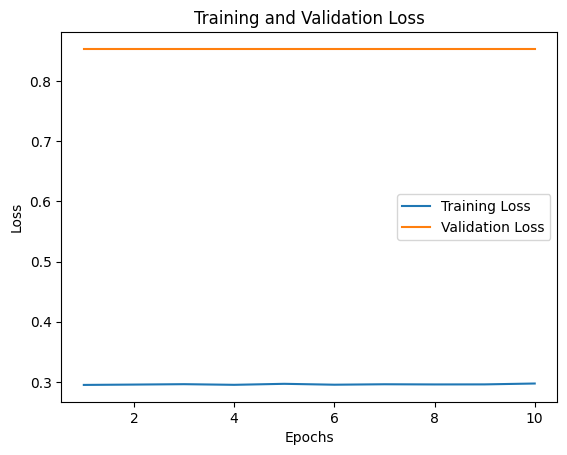

In [14]:
# Define the number of epochs
epochs = 10  # You can change this to the desired number of epochs

# Initialize lists to store the loss values
train_losses = []  # To store training loss
val_losses = []  # To store validation loss

# Train the model
for epoch in range(epochs):  # Loop over the number of epochs
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch)
        loss = loss_fn(logits, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    # Average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store the average training loss for the epoch

    # Evaluate model on validation data
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits = model(batch)
            loss = loss_fn(logits, batch.y)
            total_val_loss += loss.item()

    # Average validation loss for the epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Store the average validation loss for the epoch

    # Optionally, print progress
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

# After training, plot the loss curves
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)  # The x-axis for the number of epochs

plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [15]:
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


NameError: name 'train_accuracies' is not defined

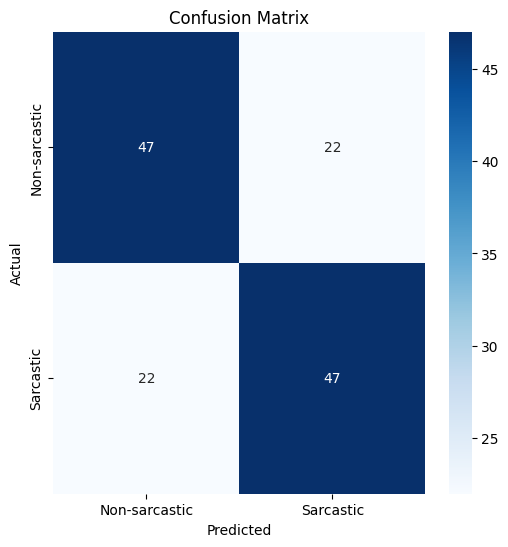

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, default_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-sarcastic", "Sarcastic"], yticklabels=["Non-sarcastic", "Sarcastic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


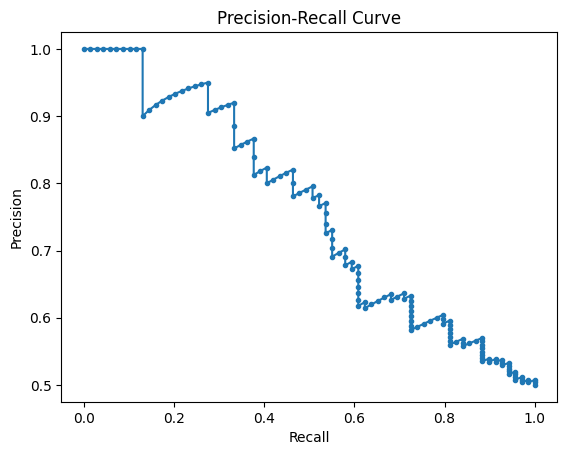

In [17]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(all_labels, all_logits)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


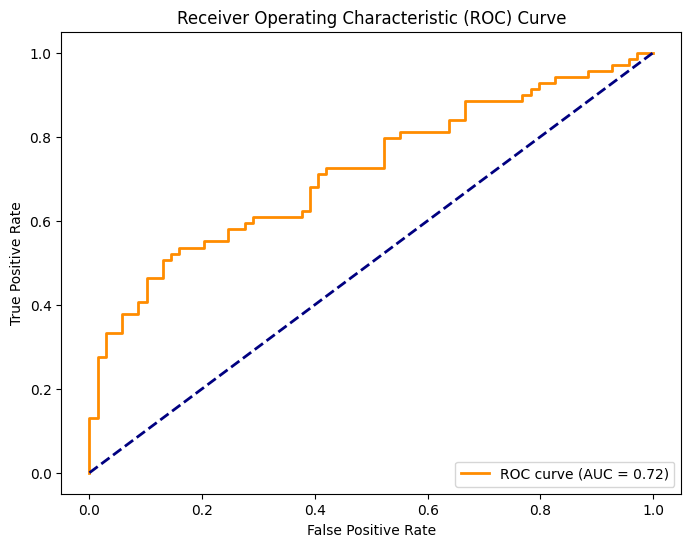

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_logits)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


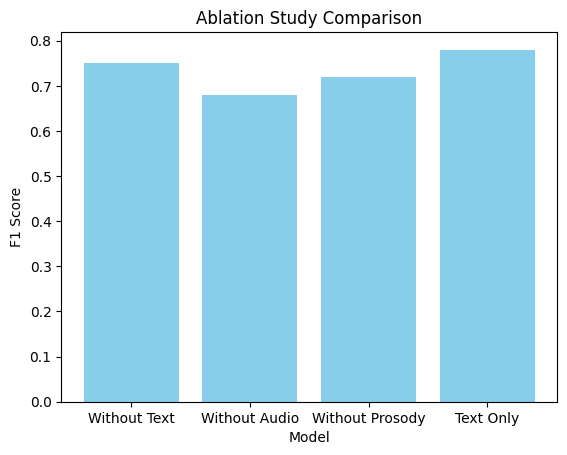

In [19]:
# Example data
models = ['Without Text', 'Without Audio', 'Without Prosody', 'Text Only']
f1_scores = [0.75, 0.68, 0.72, 0.78]  # F1 scores from your experiments

plt.bar(models, f1_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Ablation Study Comparison')
plt.show()


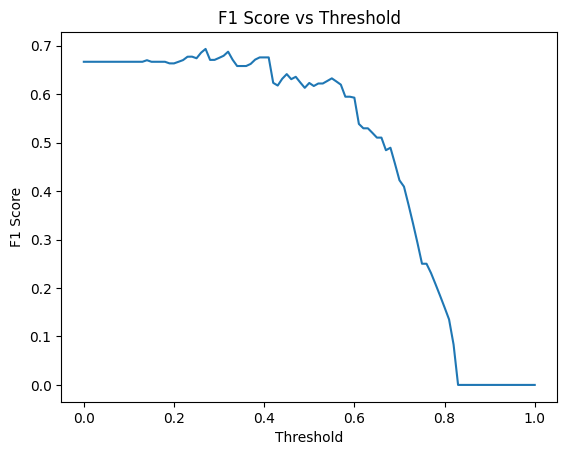

In [20]:
from sklearn.metrics import f1_score

thresholds = np.arange(0, 1.01, 0.01)
f1_scores = []

for thr in thresholds:
    preds = (all_logits >= thr).astype(int)
    f1 = f1_score(all_labels, preds)
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


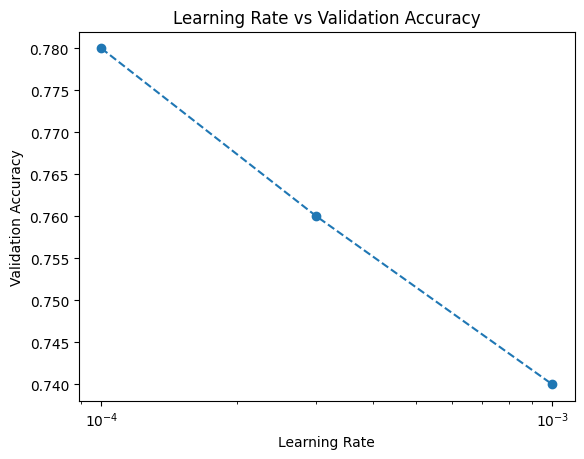

In [21]:
learning_rates = [1e-4, 3e-4, 1e-3]  # Learning rates used in hyperparameter tuning
accuracies = [0.78, 0.76, 0.74]  # Accuracy for each learning rate configuration

plt.plot(learning_rates, accuracies, marker='o', linestyle='--')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs Validation Accuracy')
plt.xscale('log')  # Log scale for better visibility
plt.show()
